In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import math
import torch.nn.functional as F

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
import os
from torchvision.utils import save_image

sample_dir = 'samples'
os.makedirs(sample_dir, exist_ok=True)

# We first work on a 2D dataset with size 28x28

In [4]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 1e-5
image_size = 28 * 28

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)
z_dim = 32

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\HP\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-H

In [7]:
# visualization

train_dataset.montage(length=1)

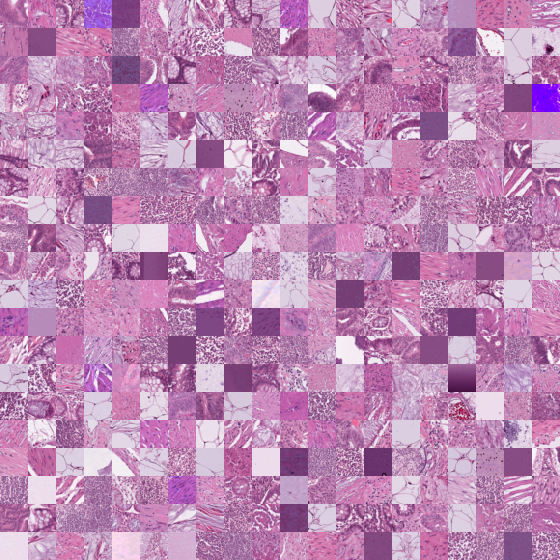

In [8]:
# montage

train_dataset.montage(length=20)

# Then, we define a basic VAE.

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [10]:
class UnFlatten(nn.Module):
    def forward(self, x):
        # Adjusted for 7x7 spatial dimensions, 128 channels
        return x.view(x.size(0), 128, 7, 7)

In [11]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, z_dim=32):
        super(VAE, self).__init__()

        # LeNet-style encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 6, kernel_size=5, padding=2),  # Output: 6×28×28
            nn.Sigmoid(),
            nn.AvgPool2d(2, 2),                                       # Output: 6×14×14

            nn.Conv2d(6, 16, kernel_size=5),                          # Output: 16×10×10
            nn.Sigmoid(),
            nn.AvgPool2d(2, 2),                                       # Output: 16×5×5

            Flatten()                                                 # 16×5×5 = 400
        )

        self.fc1 = nn.Linear(400, z_dim)
        self.fc2 = nn.Linear(400, z_dim)
        
        # Adjusted fc3 output size to match 128 channels, 7x7 spatial for UnFlatten
        self.fc3 = nn.Linear(z_dim, 128 * 7 * 7)  # 128 * 49 = 6272

        self.decoder = nn.Sequential(
            UnFlatten(),  # [B, 128, 7, 7]
            # Layer 1: 7x7 -> 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Layer 2: 14x14 -> 28x28
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def bottleneck(self, h):
        mu = self.fc1(h)
        logvar = self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        h = self.fc3(z)
        x_reconst = self.decoder(h)
        return x_reconst

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_reconst = self.decode(z)
        return x_reconst, mu, logvar

# Next, we can start to train and evaluate!

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
for epoch in range(NUM_EPOCHS):
    for i, (x, _) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        reconst_loss = nn.functional.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, NUM_EPOCHS, i+1, len(train_loader), reconst_loss.item(), kl_div.item()))
        with torch.no_grad():
            num_samples_to_save = 10 # Or any number you prefer
            z_fixed = torch.randn(num_samples_to_save, z_dim).to(device)
            out_sampled = model.decode(z_fixed).view(-1, 1, 28, 28)

            # Explicitly set nrow for sampled images. For 100 images, 10 per row makes a nice 10x10 grid.
            save_image(out_sampled, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)), nrow=10)
            
            num_reconstruct_to_save = 10 
            x_for_saving = x[:num_reconstruct_to_save] # Slice the current training batch

            # Perform reconstruction on this smaller, consistent batch
            out_reconst, _, _ = model(x_for_saving) 
            
            image_channels = 1 # Assuming MedMNIST is grayscale
            
            x_concat_to_save = torch.cat([
                x_for_saving.view(-1, image_channels, 28, 28), 
                out_reconst.view(-1, image_channels, 28, 28)
            ], dim=3)

            save_image(x_concat_to_save, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)), nrow=5) 

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/3], Step [10/704], Reconst Loss: 185595.5469, KL Div: 1129.3157
Epoch[1/3], Step [20/704], Reconst Loss: 189753.8438, KL Div: 1129.3767
Epoch[1/3], Step [30/704], Reconst Loss: 188032.8125, KL Div: 1151.1462
Epoch[1/3], Step [40/704], Reconst Loss: 189420.1562, KL Div: 1158.8920
Epoch[1/3], Step [50/704], Reconst Loss: 189385.8438, KL Div: 1161.3774
Epoch[1/3], Step [60/704], Reconst Loss: 186096.9531, KL Div: 1156.8970
Epoch[1/3], Step [70/704], Reconst Loss: 189460.9531, KL Div: 1157.3312
Epoch[1/3], Step [80/704], Reconst Loss: 186356.8750, KL Div: 1151.8794
Epoch[1/3], Step [90/704], Reconst Loss: 191758.4219, KL Div: 1119.6354
Epoch[1/3], Step [100/704], Reconst Loss: 187011.0625, KL Div: 1098.3320
Epoch[1/3], Step [110/704], Reconst Loss: 187102.5000, KL Div: 1097.3516
Epoch[1/3], Step [120/704], Reconst Loss: 186659.9062, KL Div: 1110.3710
Epoch[1/3], Step [130/704], Reconst Loss: 186916.0312, KL Div: 1137.4824
Epoch[1/3], Step [140/704], Reconst Loss: 189458.4375, KL Di

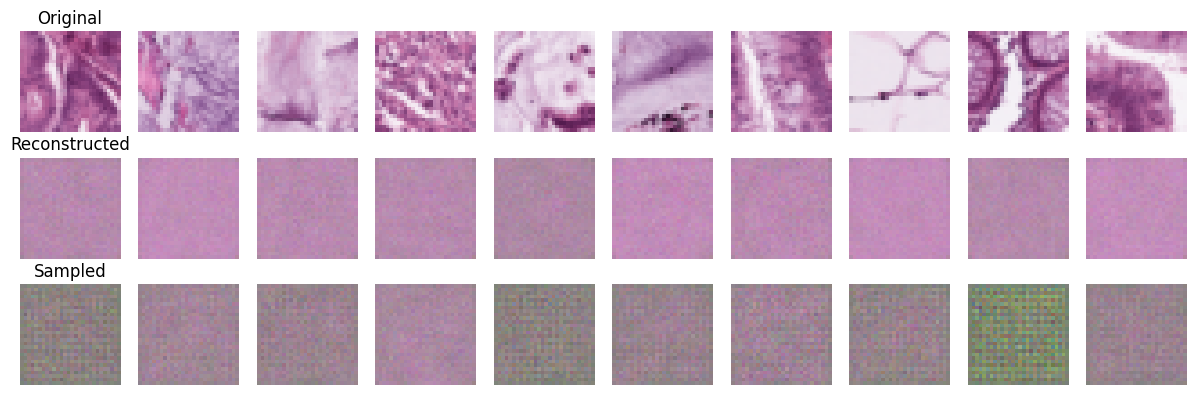

In [17]:
import matplotlib.pyplot as plt
import torch

model.eval() # set to eval mode

# ======== RECONSTRUCTED IMAGES ========
x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    x_reconst, _, _ = model(x) # x should be [B, C, H, W]

    # Move to CPU and handle potential channel dimension for plotting
    x = x.cpu()
    x_reconst = x_reconst.cpu()

# ======== SAMPLED IMAGES ========
with torch.no_grad():
    z = torch.randn(10, z_dim).to(device)
    samples = model.decode(z).cpu() # Move to CPU here

# ======== PLOT BOTH ========
fig, axes = plt.subplots(3, 10, figsize=(12, 4))

# Determine if images are grayscale or color based on the number of channels
# Assuming image_channels variable from your VAE.__init__
num_image_channels = x.shape[1] # Get channels from the loaded batch

for i in range(10):
    # Original Image
    if num_image_channels == 1:
        axes[0, i].imshow(x[i].squeeze(), cmap='gray') # Squeeze removes the channel dimension
    elif num_image_channels == 3:
        axes[0, i].imshow(x[i].permute(1, 2, 0)) # Permute to (H, W, C)
    else:
        # Handle other channel counts if necessary, or raise an error
        raise ValueError(f"Unsupported number of image channels: {num_image_channels}")
    axes[0, i].axis('off')

    # Reconstructed Image
    if num_image_channels == 1:
        axes[1, i].imshow(x_reconst[i].squeeze(), cmap='gray')
    elif num_image_channels == 3:
        axes[1, i].imshow(x_reconst[i].permute(1, 2, 0))
    else:
        raise ValueError(f"Unsupported number of image channels: {num_image_channels}")
    axes[1, i].axis('off')

    # Sampled Image
    if num_image_channels == 1:
        axes[2, i].imshow(samples[i].squeeze(), cmap='gray')
    elif num_image_channels == 3:
        axes[2, i].imshow(samples[i].permute(1, 2, 0))
    else:
        raise ValueError(f"Unsupported number of image channels: {num_image_channels}")
    axes[2, i].axis('off')

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
axes[2, 0].set_title("Sampled")

plt.tight_layout()
plt.show()